In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from matplotlib import pyplot as plt
from utils import plot_image, plot_curve, one_hot


torch.Size([512, 1, 28, 28]) torch.Size([512]) tensor(-0.4242) tensor(2.8215)


e:\文档\DL学习\Python工具包学习\Pytorch\utils.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


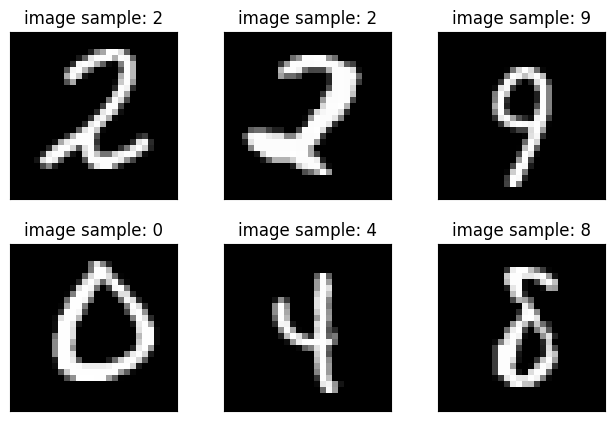

In [8]:
batch_size = 512

# step1. load dataset
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=False)
x, y = next(iter(train_loader))
print(x.shape, y.shape, x.min(), x.max())
plot_image(x, y, "image sample")

0 0 0.10906622558832169
0 10 0.09536732733249664
0 20 0.08650435507297516
0 30 0.07981373369693756
0 40 0.07634206861257553
0 50 0.07309290766716003
0 60 0.06820052117109299
0 70 0.06396233290433884
0 80 0.05904793739318848
0 90 0.057838745415210724
0 100 0.05429153889417648
0 110 0.056545864790678024
1 0 0.05349751561880112
1 10 0.051927320659160614
1 20 0.04835830256342888
1 30 0.048721008002758026
1 40 0.04556811973452568
1 50 0.04489176347851753
1 60 0.0434945672750473
1 70 0.04112805798649788
1 80 0.04099191352725029
1 90 0.04330328479409218
1 100 0.04171767458319664
1 110 0.04188648983836174
2 0 0.03914512321352959
2 10 0.03892771154642105
2 20 0.039212241768836975
2 30 0.03592284768819809
2 40 0.03687695786356926
2 50 0.035590991377830505
2 60 0.03461796045303345
2 70 0.03452087193727493
2 80 0.03686678782105446
2 90 0.033075906336307526
2 100 0.035783279687166214
2 110 0.0348692312836647


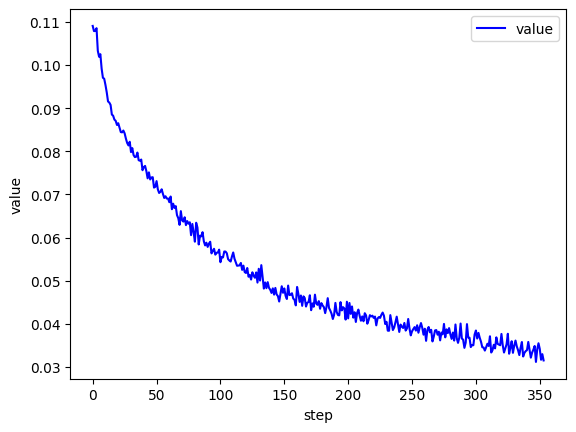

test acc: 0.8774


e:\文档\DL学习\Python工具包学习\Pytorch\utils.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


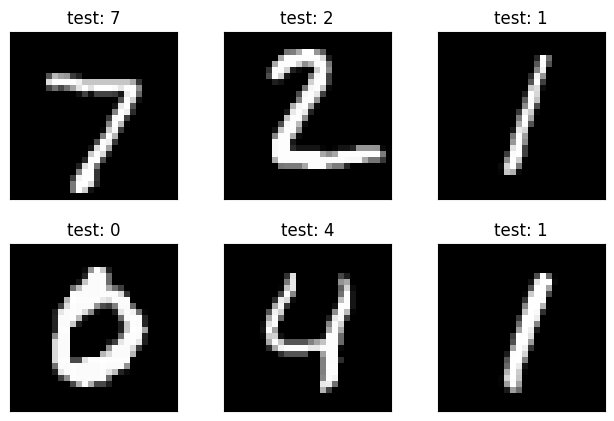

In [19]:
# 定义神经网络模型
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # xw+b
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # x: [b, 1, 28, 28]
        # h1 = relu(xw1+b1)
        x = F.relu(self.fc1(x))
        # h2 = relu(h1w2+b2)
        x = F.relu(self.fc2(x))
        # h3 = h2w3+b3
        x = self.fc3(x)

        return x

# 创建神经网络模型和优化器
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# 用于保存每次训练的损失值
train_loss = []

# 开始训练神经网络
for epoch in range(3):  # 进行3个epochs的训练

    for batch_idx, (x, y) in enumerate(train_loader):

        # x: [b, 1, 28, 28], y: [512]
        # 将输入图像数据x的形状从[b, 1, 28, 28]转换为[b, 784]
        x = x.view(x.size(0), 28*28)
        # 将输入x输入到神经网络net中进行前向传播，得到输出out
        out = net(x)
        # 将标签数据y转换为one-hot编码
        y_onehot = one_hot(y)
        # 计算预测输出out与one-hot编码标签y_onehot之间的均方误差损失
        loss = F.mse_loss(out, y_onehot)

        # 将优化器中的梯度缓存清零，避免梯度累积影响参数更新
        optimizer.zero_grad()
        # 反向传播，计算损失对模型参数的梯度
        loss.backward()
        # 根据梯度更新模型参数
        optimizer.step()

        # 将每个批次的训练损失保存在train_loss列表中
        train_loss.append(loss.item())

        # 每隔10个批次，打印当前epoch、批次索引和损失
        if batch_idx % 10 == 0:
            print(epoch, batch_idx, loss.item())

# 绘制训练损失曲线
plot_curve(train_loss)

# 在测试集上进行评估，计算模型的准确率
total_correct = 0
for x, y in test_loader:
    x = x.view(x.size(0), 28*28)
    out = net(x)
    # out: [b, 10] => pred: [b]
    pred = out.argmax(dim=1)
    correct = pred.eq(y).sum().float().item()
    total_correct += correct

total_num = len(test_loader.dataset)
acc = total_correct / total_num
print('test acc:', acc)

# 获取测试集中的一个批次数据样本，并绘制预测结果
x, y = next(iter(test_loader))
out = net(x.view(x.size(0), 28*28))
pred = out.argmax(dim=1)
plot_image(x, pred, 'test')